In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## PRN : 230940141009
## Name: Kartik Bhaskar Narayane

# Introduction to AI and OpenVino
## Assignment 05 - Santander XGBOOST

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', 'input')

# set location of inputs for this module
moduleDir = 'santander'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Question:
* What did you do too address missing values?
* What data wrangling do you recommend?

In [7]:
train_df = pd.read_csv(os.path.join(inpDir,moduleDir,'train.csv'))
test_df = pd.read_csv(os.path.join(inpDir,moduleDir,'test.csv'))
display(train_df.head())
display(test_df.head())

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   
3                      0.0                      0.0  ...   
4                      0.0                      0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   saldo_medio_var44_ult1  saldo_medio_var44_ult3          var38  TARGET  
0                     0.0                     0.0   39205.170000       0  
1                     0.0                     0.0   49278.030000       0  
2                     0.0                     0.0   67333.770000       0  
3                     0.0                     0.0   64007.970000       0  
4                     0.0                     0.0  117310.979016       0  

[5 rows x 371 columns]

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   2     2     32                 0.0                      0.0   
1   5     2     35                 0.0                      0.0   
2   6     2     23                 0.0                      0.0   
3   7     2     24                 0.0                      0.0   
4   9     2     23                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   
3                      0.0                      0.0  ...   
4                      0.0                      0.0  ...   

   saldo_medio_var29_ult3  saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   saldo_medio_var33_ult1  saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   

   saldo_medio_var44_hace3  saldo_medio_var44_ult1  saldo_medio_var44_ult3  \
0                      0.0                     0.0                     0.0   
1                      0.0                     0.0                     0.0   
2                      0.0                     0.0                     0.0   
3                      0.0                     0.0                     0.0   
4                      0.0                     0.0                     0.0   

       var38  
0   40532.10  
1   45486.72  
2   46993.95  
3  187898.61  
4   73649.73  

[5 rows x 370 columns]

In [8]:
test_df.info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [9]:
test_df.describe()
train_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

In [10]:
train_df['TARGET'].value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        0
3        0
4        0
        ..
76015    0
76016    0
76017    0
76018    0
76019    0
Name: TARGET, Length: 76020, dtype: int64>

In [11]:
class_names=train_df['TARGET'].unique()
class_names

array([0, 1])

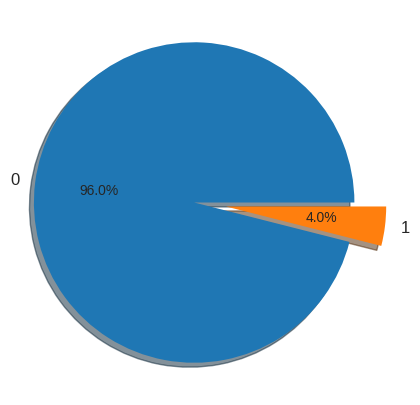

In [12]:
fig, ax =plt.subplots(figsize=(5,5))
explode = (0,0.2)#only explode the single slice{i.e 1}
ax.pie(train_df['TARGET'].value_counts(),explode=explode,labels =class_names,autopct='%1.1f%%',shadow=True,startangle=0)
ax.axis('equal') #Equal aspect ratio ensures that pie is drawn as acircle.
plt.show()

In [13]:
train_df.keys()

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [14]:
features_df = pd.DataFrame(train_df.ID, columns= train_df.var15) 
features_df.head()

Empty DataFrame
Columns: [23, 34, 23, 37, 39, 23, 27, 26, 45, 25, 42, 26, 51, 43, 33, 30, 44, 36, 55, 28, 23, 27, 35, 54, 42, 40, 23, 25, 24, 23, 14, 66, 26, 25, 42, 23, 39, 39, 23, 24, 50, 22, 25, 24, 62, 23, 23, 42, 24, 60, 42, 22, 64, 76, 26, 23, 40, 26, 31, 23, 38, 41, 23, 26, 25, 56, 26, 23, 23, 24, 23, 28, 35, 24, 25, 51, 72, 25, 23, 24, 45, 23, 27, 36, 23, 23, 26, 23, 44, 68, 5, 25, 25, 72, 23, 25, 23, 56, 25, 23, ...]
Index: []

[0 rows x 76020 columns]

In [15]:
labels = train_df.TARGET
labels

0        0
1        0
2        0
3        0
4        0
        ..
76015    0
76016    0
76017    0
76018    0
76019    0
Name: TARGET, Length: 76020, dtype: int64

In [16]:
label_names = train_df.var15
label_names

0        23
1        34
2        23
3        37
4        39
         ..
76015    48
76016    39
76017    23
76018    25
76019    46
Name: var15, Length: 76020, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split( train_df, labels,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [18]:
# Scaling is important for XGBoost 

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [19]:
clf = xgb.XGBClassifier(tree_method = "hist", 
                        random_state=RANDOM_STATE)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=24, ...)

In [20]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 1.0


Text(0.5, 1.0, 'test')

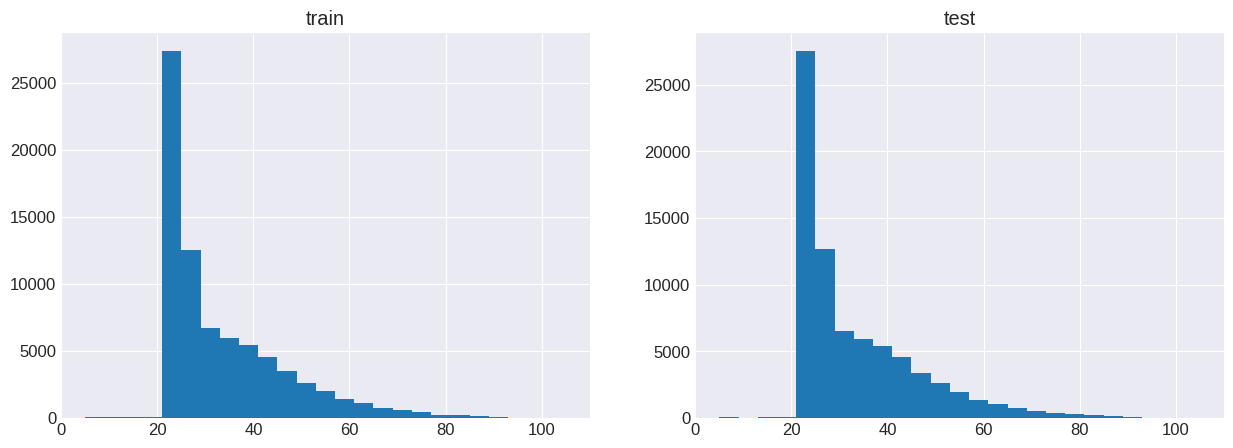

In [21]:
#var15 age
fig ,axes = plt.subplots(1,2)
ax = axes[0]
train_df['var15'].hist(bins=25,ax=ax)
ax.set_title('train')
ax = axes[1]
test_df['var15'].hist(bins=25,ax=ax)
ax.set_title('test')

In [22]:
print(len(train_df['TARGET'][train_df.var15<23]))
print(sum(train_df['TARGET'][train_df.var15<23]))


1212
0


In [23]:
#create another column with count of zeros
train_df['n0']=(train_df==0).sum(axis=1)

print(train_df.shape)

(76020, 372)


In [24]:
#remove constant columns (std =0)

drop_cols = []

for col in train_df.columns:
    if train_df[col].std() ==0:
        drop_cols.append(col)
train_df.drop(drop_cols,axis=1,inplace=True)
test_df.drop(drop_cols,axis=1,inplace=True)

print(train_df.shape,train_df.shape)


(76020, 338) (76020, 338)


In [25]:
#keep track of columns to remove

drop_cols = []
cols = train_df.columns
#loop thru cols to find equal values
for i in range(len(cols)-1):
    
    v=train_df[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train_df[cols[j]].values):
            drop_cols.append(cols[j])
        
print(len(drop_cols))
print(drop_cols)

29
['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']


In [26]:
from collections import Counter
import matplotlib.patheffects as PathEffects

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

X,y = make_classification(n_classes=2,class_sep=2,weights=[0.1,0.9],n_informative=3,n_redundant=1,flip_y=0,n_features=20,n_clusters_per_class=1,n_samples=N_SAMPLES,random_state=RANDOM_STATE)
print('origin dataset shape %s' % Counter(y))
sm = SMOTE(random_state = RANDOM_STATE)
X_res,y_res =sm.fit_resample(X,y)
print('Resampled dataset shape %s' % Counter(y_res))

origin dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({1: 900, 0: 900})
